# Обробка сигналів - лабораторна робота 1
Виконав: Басистий Олег

In [19]:
# imports
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

## Завдання 0. Тривалість дискретних сигналів

In [17]:
def signal_len(signal, freq):
    return len(signal) / freq

## Завдання 1. Запис сигналів з внутрішніх датчиків

## Завдання 2. Запис звуку з пристрою

## Завдання 3. Зчитання даних з ЕЕГ

Зчитаємо EEG дані з запропонованих файлів. Для цього, визначимо функцію-завгортку навколо методу `loadmat` з бібліотеки `scipy`, що читає MATLAB файли. Замість словника - повертається numpy список time-series сигналу.

In [50]:
def load_mat_signal(file_path):
    return np.array(loadmat(file_path)['sig'][0])

Частота дискретизації вхідних EEG даних - 256 Гц.

In [51]:
healthy = load_mat_signal('data/eeg/eeg_healthy_1.mat')
sick = load_mat_signal('data/eeg/eeg_sick_1.mat')
sample_rate = 256

In [225]:
def plot_signal(signal, s_rate, title = 'EEG Signal', offset=0, ylabel="Amplitude, muV"):
    time = np.arange(offset, offset + signal_len(signal, s_rate), 1/s_rate)
    plt.figure(figsize=(12, 4))
    plt.plot([0] * len(time), color='black', linestyle='--', linewidth=0.8)
    plt.plot(time, signal, color='lightcoral')
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(left=offset, right=time[-1])
    plt.tight_layout()
    plt.show()

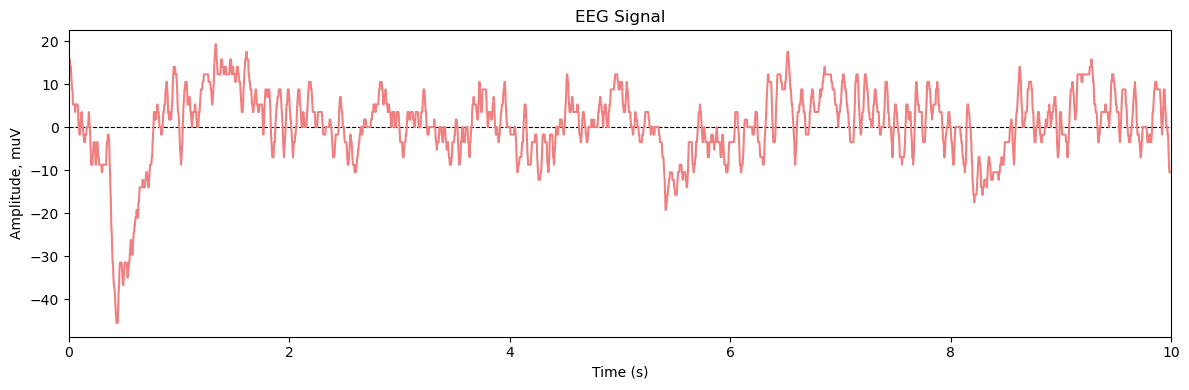

In [226]:
plot_signal(healthy, sample_rate)

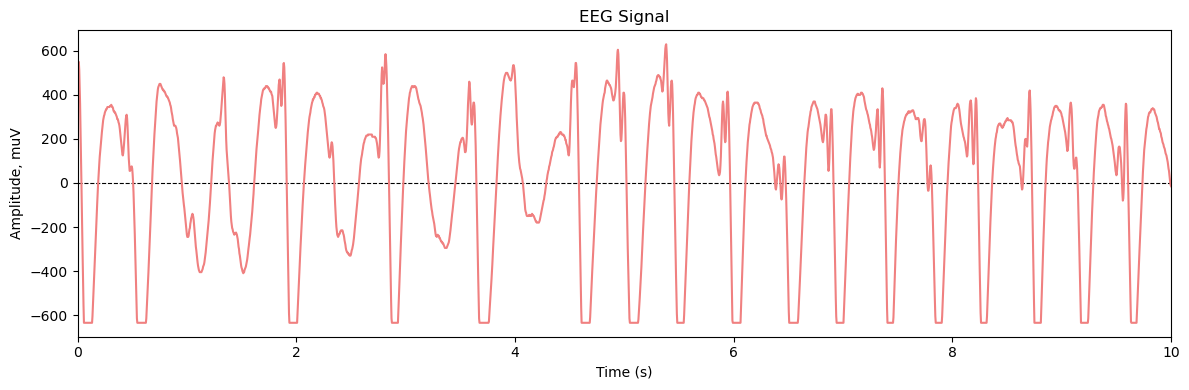

In [227]:
plot_signal(sick, sample_rate)

## Завдання 4. Функція для виводу ділянки сигналів

Задля візуалізації, можна скористатися функцією, визначеною раніше для EEG. 

Функція викличе помилку за наступних умов:
* якщо початковий час більший за кінцевий
* якщо початковий або кінцевий час від'ємний (окрім випадку де end_time = -1, приймаємо це як останній time stamp задля зручності)
* якщо кінцевий час більший за кінецвий час сигналу  

Наявні аргументи додаткові аргументи `title` - "назва" для графіку, та `return_signal` - флажок, чи слід повертати оновлений часовий ряд.

In [222]:
def plot_signal_parted(signal, s_rate, start = 0, end = -1, title = 'EEG Signal', return_signal = False, ylabel="Amplitude, muV"):
    if start < 0 or (end != -1 and end < 0) or (end != -1 and end <= start) \
     or end > signal_len(signal, s_rate):
        raise ValueError("Invalid start or end time.")
    start_idx = int(start * s_rate)
    end_idx = int(end * s_rate) if end != -1 else len(signal)
    signal = signal[start_idx:end_idx]
    plot_signal(signal, s_rate, title=title, offset=start, ylabel=ylabel)
    if return_signal:
        return signal


Перевіримо функцію на даних з попередніх завдань

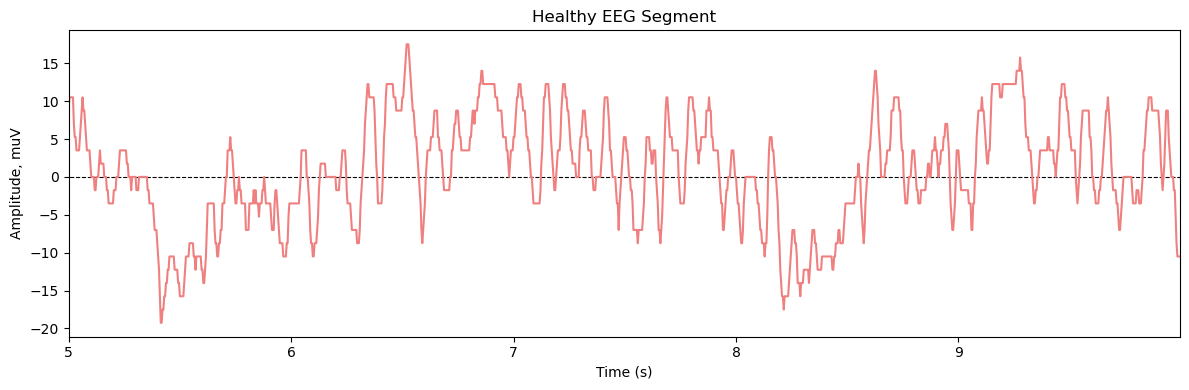

Validation check
   length match: True
   items match:  True



In [223]:
half_healthy = plot_signal_parted(healthy, sample_rate, start=5, end=10, title='Healthy EEG Segment', return_signal=True)
print(f"""Validation check
   length match: {len(half_healthy) == 5 * sample_rate}
   items match:  {all(half_healthy == healthy[5 * sample_rate:10 * sample_rate])}
""")

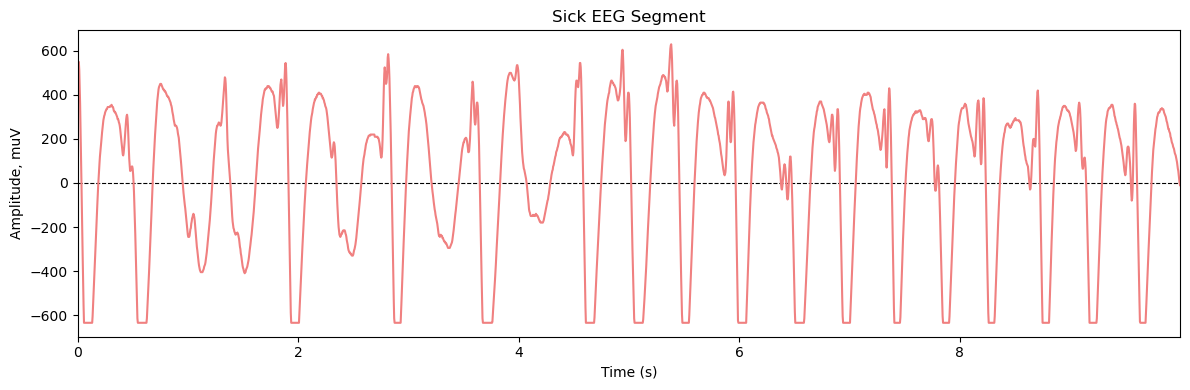

Validation check
   length match: True
   items match:  True


In [224]:
one_third_sick = plot_signal_parted(sick, sample_rate, start=0, end=10, title='Sick EEG Segment', return_signal=True)
print(f"""Validation check
   length match: {len(one_third_sick) == 10 * sample_rate}
   items match:  {all(one_third_sick == sick[:10 * sample_rate])}""")

## Завдання 5. Візуалізація EСG сигналів

In [132]:
def read_ecg_signal(file_path):
    return np.load(file_path).

In [197]:
norm = read_ecg_signal('data/ecg/ecg_norm.npz')
anomaly = read_ecg_signal('data/ecg/ecg_anomaly.npz')

In [151]:
def get_ecg_info(ecg_signal):
    print(f"Keys: {ecg_signal.files}")
    for key in ecg_signal.files:
        print(f"{key}: {ecg_signal[key]}")

In [152]:
get_ecg_info(norm)
print("="*100)
get_ecg_info(anomaly)

Keys: ['description', 'source', 'fs', 'units', 'signal', 'labels', 'labels_indexes', 'source_start', 'source_end']
description: 
source: mitdb/100
fs: 250
units: mV
signal: [-0.07272279 -0.06141497 -0.08927172 ... -0.25111498 -0.26430862
 -0.25950177]
labels: ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
labels_indexes: [  15  215  424  631  838 1040 1238 1433 1635 1845 2054 2261 2463 2657
 2856]
source_start: 10000
source_end: 13000
Keys: ['description', 'source', 'fs', 'units', 'signal', 'labels', 'labels_indexes', 'source_start', 'source_end']
description: Patient with paced beats(using pacemaker device)
source: mitdb/107
fs: 250
units: mV
signal: [0.18942029 0.19776157 0.20501576 ... 0.09178647 0.0801407  0.07180146]
labels: ['/' '/' '/' '/' '/' '/' '/' '/' '/' '/' '/' '/']
labels_indexes: [  34  253  473  690  894 1097 1310 1527 1745 1963 2177 2386]
source_start: 11000
source_end: 13500


Оскільки окрім самого сигналу - слід наносити биття серця, потрібно визначити окрему функцію для ECG.

In [228]:
def plot_ecg(ecg_signal):
    sample_rate = ecg_signal['fs']
    signal = ecg_signal['signal']
    label_idx = ecg_signal['labels_indexes']
    time = np.arange(0, signal_len(signal, sample_rate), 1/sample_rate)
    plt.figure(figsize=(20, 7))
    plt.plot(time, signal, color='lightcoral')
    for idx in label_idx:
        plt.scatter(idx / sample_rate, signal[idx], color='skyblue', s=50, label="Heart beat" if idx == label_idx[0] else "")
    plt.xlim(left=0, right=time[-1])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude, mV')
    plt.legend()
    plt.show()

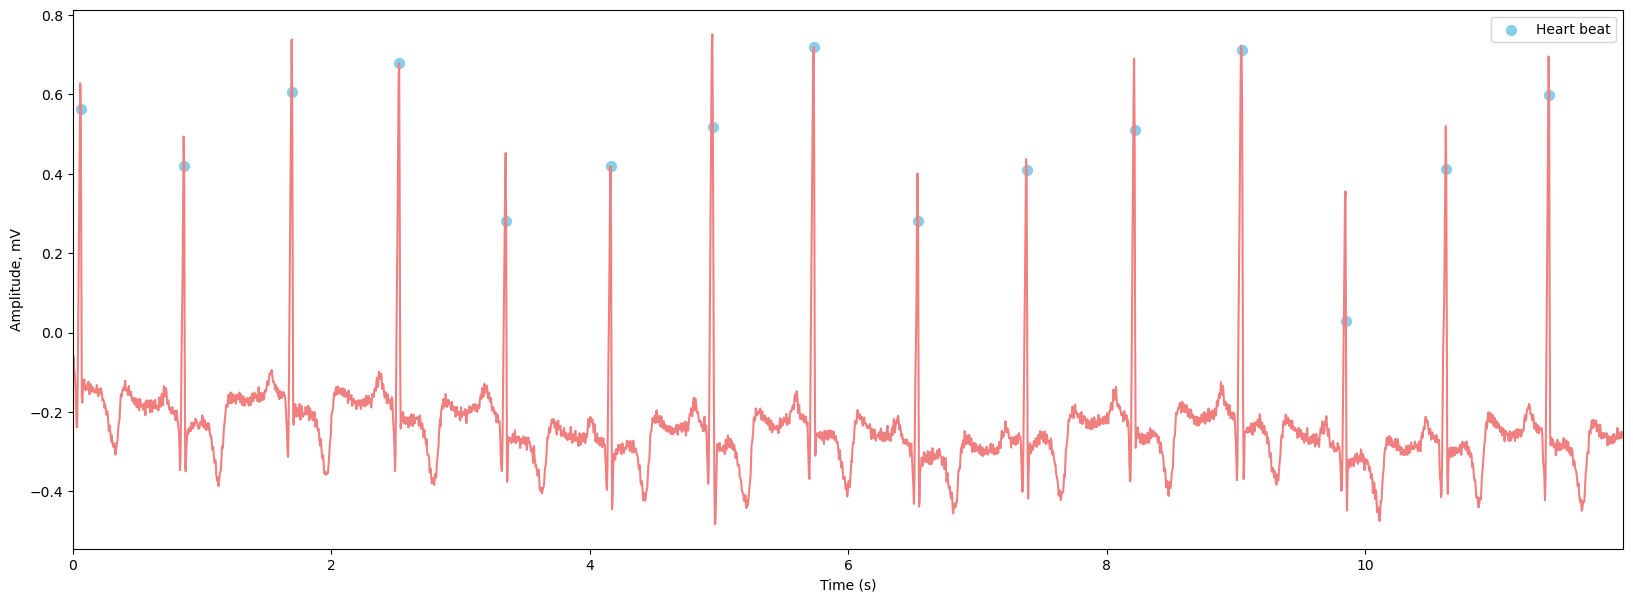

In [229]:
plot_ecg(norm)

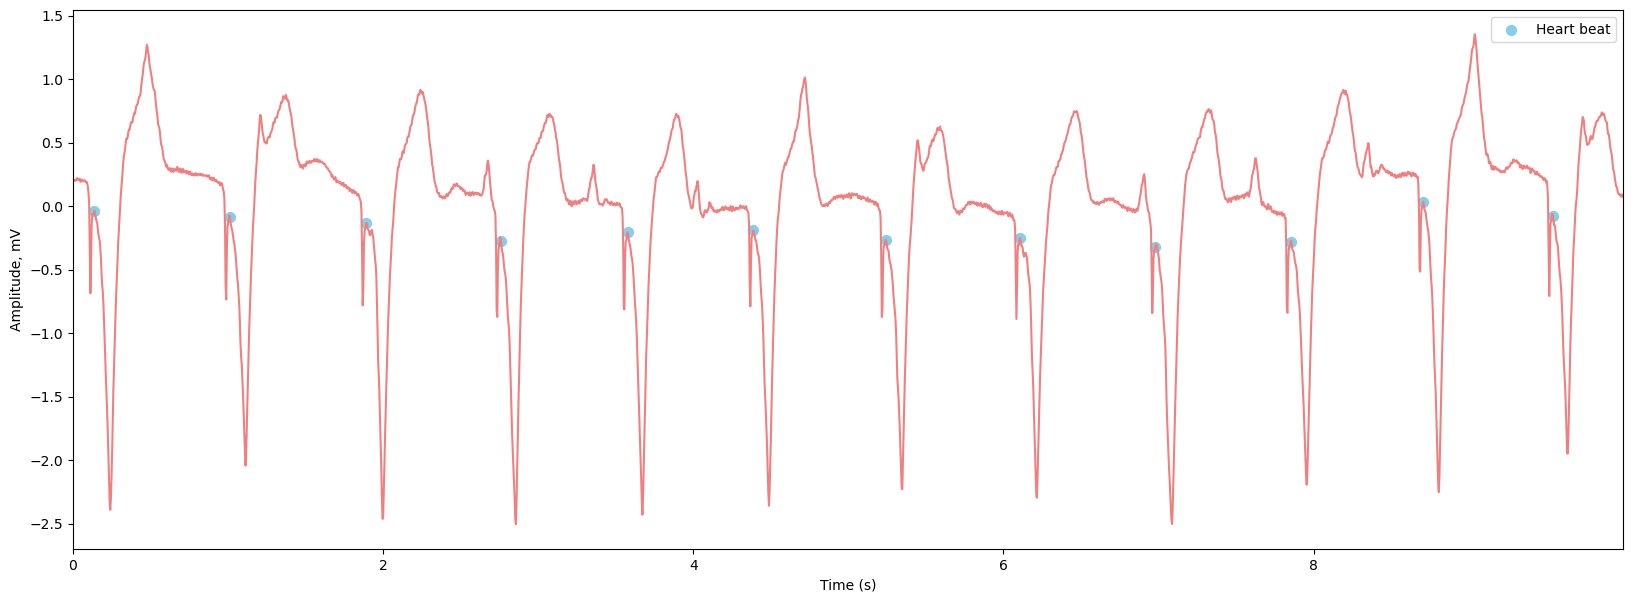

In [230]:
plot_ecg(anomaly)